# Load Data

In [ ]:
import os
import time

# spark imports
# from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.recommendation import ALS,ALSModel
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# Prepare data
rating_data = spark.read.csv("hdfs://devenv/user/spark/als/rating_man.csv",
                            inferSchema=True,header=True)

In [ ]:
rating_data.printSchema()
rating_data.show(3)

+-----------+--------+----------+
| LikeUserId|OutfitId|max_rating|
+-----------+--------+----------+
|     kajira|18221278|         3|
| yusarock69|18221278|         3|
|boc39nicole|18221278|         3|
+-----------+--------+----------+
only showing top 3 rows



In [ ]:
labelIndexer = StringIndexer(inputCol='LikeUserId'\
                , outputCol='LikeUser_index')\
                .fit(rating_data)

rating_data=labelIndexer.transform(rating_data)
rating_data.show(5)

+-----------+--------+----------+--------------+
| LikeUserId|OutfitId|max_rating|LikeUser_index|
+-----------+--------+----------+--------------+
|     kajira|18221278|         3|        1099.0|
| yusarock69|18221278|         3|        5151.0|
|boc39nicole|18221278|         3|          38.0|
|ryo08116679|18221278|         3|         438.0|
|   rose0707|18221278|         3|         566.0|
+-----------+--------+----------+--------------+
only showing top 5 rows

root
 |-- LikeUserId: string (nullable = true)
 |-- OutfitId: integer (nullable = true)
 |-- max_rating: integer (nullable = true)
 |-- LikeUser_index: double (nullable = false)



In [ ]:
outfit_data = spark.read.csv("hdfs://devenv/user/spark/als/outfit_man.csv",
                            inferSchema=True,header=True)

In [ ]:
outfit_data.show(3, truncate=False)

+--------+----------------------------------------------------+-------------------------------+
|OutfitId|OutfitSet                                           |OutfitUrl                      |
+--------+----------------------------------------------------+-------------------------------+
|18481894|['黑色outerwear', '灰色top', '灰色top', '灰色pants']|https://wear.tw/genji/18481894/|
|18450625|['橘色top', '白色top', '橘色pants']                 |https://wear.tw/genji/18450625/|
|18450622|['橙色outerwear', '橘色top', '白色top', '橙色pants']|https://wear.tw/genji/18450622/|
+--------+----------------------------------------------------+-------------------------------+
only showing top 3 rows



# Training Model>> First Version: Pilot Trial

In [ ]:
train_data, test_data = rating_data.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=5,userCol="LikeUser_index",itemCol="OutfitId",ratingCol="max_rating" , coldStartStrategy="drop")
model1 = als.fit(train_data)

In [ ]:
# Transform the test data using the model to get predictions
predicted_test_data = model1.transform(test_data)

In [ ]:
# Evalute model performance with test set
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="max_rating", metricName="rmse")
print("rmse: {}".format(evaluator.evaluate(predicted_test_data)))

rmse: 0.0989751236512028


In [ ]:
# Specify the number of outfits you would like to recommand for each user
user_outfit = model1.recommendForAllUsers(3)
user_outfit.show(100, truncate=False)

+--------------+------------------------------------------------------------------------+
|LikeUser_index|recommendations                                                         |
+--------------+------------------------------------------------------------------------+
|148           |[[18359983, 0.97323203], [18295387, 0.9599794], [13920013, 0.9322747]]  |
|463           |[[18359983, 0.9714847], [18295387, 0.95841885], [13920013, 0.93157756]] |
|471           |[[18359983, 0.971713], [18295387, 0.95873755], [15905449, 0.932237]]    |
|496           |[[18359983, 0.97198796], [18295387, 0.9589887], [15905449, 0.9324418]]  |
|833           |[[18359983, 0.97304857], [18295387, 0.9599049], [15905449, 0.932587]]   |
|1088          |[[18359983, 0.9735856], [18295387, 0.96029097], [15905449, 0.932164]]   |
|1238          |[[18359983, 0.97169095], [18295387, 0.9587462], [15905449, 0.93245566]] |
|1342          |[[18359983, 0.9720351], [18295387, 0.9585998], [15905449, 0.9289431]]   |
|1580     

In [ ]:
# The users who are most likely to like a particular outfit
outfit_uers = model1.recommendForAllItems(3)
outfit_uers.show(100, truncate=False)

+--------+--------------------------------------------------------------+
|OutfitId|recommendations                                               |
+--------+--------------------------------------------------------------+
|14097300|[[113176, 2.7316096], [257802, 2.722375], [65234, 2.718701]]  |
|14185780|[[113176, 2.7397695], [257802, 2.7294195], [65234, 2.7241888]]|
|15853970|[[113176, 2.738259], [257802, 2.7275712], [65234, 2.7202075]] |
|15989470|[[113176, 2.739381], [257802, 2.7296178], [65234, 2.7226646]] |
|16162450|[[113176, 2.739698], [257802, 2.7286615], [65234, 2.7210813]] |
|16231400|[[113176, 2.7396057], [257802, 2.7292945], [65234, 2.722003]] |
|18270470|[[113176, 2.7412283], [257802, 2.7256293], [65234, 2.718815]] |
|18326500|[[113176, 2.7395535], [257802, 2.7212896], [65234, 2.7141964]]|
|16249881|[[113176, 2.7405608], [257802, 2.7309866], [65234, 2.7227292]]|
|18420681|[[113176, 2.7408047], [257802, 2.7246108], [65234, 2.7175581]]|
|15942582|[[113176, 2.7401295], [25780

In [ ]:
# Generate top 10 outfit recommendations for a specified set of users
user_index=rating_data.select('LikeUser_index').where(rating_data.LikeUserId=='kk91ss59kk')
TargetUser_outfit=model1.recommendForUserSubset(user_index, 10)
TargetUser_outfit.show(3, truncate=False)

+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|LikeUser_index|recommendations                                                                                                                                                                                                                     |
+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|7170          |[[15831021, 2.686722], [16161057, 2.6867115], [15815331, 2.6842105], [13998898, 2.6838338], [14072669, 2.6835039], [18404366, 2.6718595], [15831033, 2.6669388], [13805152, 2.665279], [16072948, 2.6616557], [18230863, 2.6512232]]|
+--------------+

# Training Model>> Second Version: Find the best model

In [ ]:
train_data, validation_data, test_data = rating_data.randomSplit([0.6, 0.2, 0.2])

In [ ]:
def train_ALS(train_data, validation_data, num_iterations , reg_param, ranks):
    # initial
    bestValidationRmse = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            als = ALS(
                userCol="LikeUser_index",itemCol="OutfitId",ratingCol="max_rating", 
                coldStartStrategy="drop",maxIter=num_iterations ,rank=rank,regParam=reg)          
            model=als.fit(train_data)
            # make prediction
            predicted_validation_data = model.transform(validation_data)
            # Evalute model performance with validation set
            evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="max_rating", metricName="rmse")
            error = evaluator.evaluate(predicted_validation_data)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < bestValidationRmse:
                bestValidationRmse = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train_data, validation_data, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.10633080994334411
8 latent factors and regularization = 0.01: validation RMSE is 0.07783499294962103
8 latent factors and regularization = 0.05: validation RMSE is 0.08886845658809994
8 latent factors and regularization = 0.1: validation RMSE is 0.1208120533995013
8 latent factors and regularization = 0.2: validation RMSE is 0.2111962551263119
10 latent factors and regularization = 0.001: validation RMSE is 0.11071444037596838
10 latent factors and regularization = 0.01: validation RMSE is 0.07749575382538382
10 latent factors and regularization = 0.05: validation RMSE is 0.08950533252500167
10 latent factors and regularization = 0.1: validation RMSE is 0.1211641581752122
10 latent factors and regularization = 0.2: validation RMSE is 0.2111915193966235
12 latent factors and regularization = 0.001: validation RMSE is 0.11465289042094093
12 latent factors and regularization = 0.01: validation RMSE is 0.07654958762055838
12

In [ ]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    errors = []
    for num_iterations in arr_iters:
        
        als = ALS(userCol="LikeUser_index",itemCol="OutfitId",ratingCol="max_rating", 
                coldStartStrategy="drop",maxIter=num_iterations ,rank=rank,regParam=reg)          
        model=als.fit(train_data)
        # make prediction
        predicted_validation_data = model.transform(validation_data)
        # Evalute model performance with validation set
        evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="max_rating", metricName="rmse")
        error = evaluator.evaluate(predicted_validation_data)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

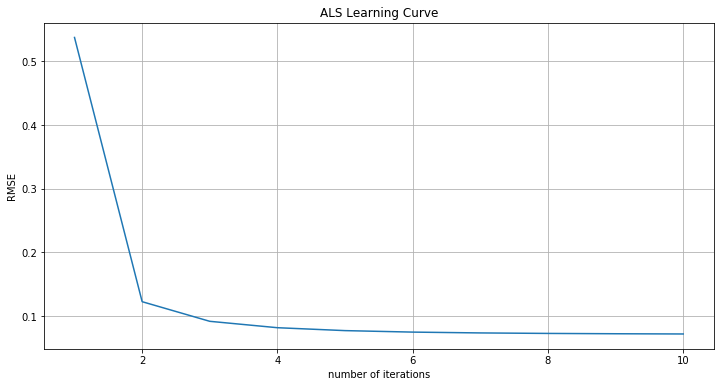

In [ ]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train_data, validation_data, 0.01, 20)

In [ ]:
final_model.save("als/myCollaborativeFilter_man_v2")

# Model Reload & Test Data Prediction

In [ ]:
model = ALSModel.load("als/myCollaborativeFilter_man_v2")

In [ ]:
# make prediction using test data
predicted_test_data = model.transform(test_data)
# Evalute model performance with test set
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="max_rating", metricName="rmse")
error = evaluator.evaluate(predicted_test_data)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.0729


# Model Reload & Prediction

In [ ]:
model = ALSModel.load("als/myCollaborativeFilter_man_v2")

### Prediction Method1 : all the training datas include fav_item

In [ ]:
# return all outfitId(s) of the item which user upload 
def get_outfitId(outfit_data, fav_item_list):
    outfitId_list = []
    for outfit in fav_item_list:
        outfitIds = outfit_data \
            .filter(outfit_data.OutfitSet.like('%{}%'.format(outfit))) \
            .select('OutfitId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        outfitId_list.extend(outfitIds)
    return list(set(outfitId_list))


# return top n outfit recommendation based on user's item upload
def make_recommendation(best_model_params,TargetUserId,ratings_data, outfit_data, 
                        fav_item_list, n_recommendations):
   
    outfitId_list = get_outfitId(outfit_data, fav_item_list)
    train_data=rating_data.filter(rating_data.OutfitId.isin(outfitId_list)) 
      
    # train best ALS only including fav_item
    als = ALS(
        userCol="LikeUser_index",itemCol="OutfitId",ratingCol="max_rating", 
        coldStartStrategy="drop",
        maxIter=best_model_params.get('maxIter', None),
        rank=best_model_params.get('rank', None),
        regParam=best_model_params.get('regParam', None))
    
    model=als.fit(train_data)
    
    user_index=rating_data.select('LikeUser_index').where(rating_data.LikeUserId==TargetUserId)
    TargetUser_outfit=model.recommendForUserSubset(user_index,n_recommendations).collect()   
    topn_ids=[row['OutfitId'] for row in TargetUser_outfit[0]['recommendations']] #list 
    url=outfit_data.filter(outfit_data.OutfitId.isin(topn_ids)).select('OutfitUrl').rdd.map(lambda r: r[0]).collect()
    return url

In [ ]:
# my favorite outfits>> return "outfitId"
fav_item_list = ['白色top']
TargetUserId='kajira'

# get recommends
print('Recommendations for {}:'.format(fav_item_list[0]))
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.01},
    TargetUserId=TargetUserId,ratings_data=rating_data,outfit_data=outfit_data,
    fav_item_list=fav_item_list, n_recommendations=3)

for i, outfitIds in enumerate(recommends):
    print('{0}: {1}'.format(i+1,outfitIds))

Recommendations for 白色top:
1: https://wear.tw/murasakibaru/14185733/
2: https://wear.tw/yoshiojazzmaster/18339088/
3: https://wear.tw/vivacematsu/18316940/


### Prediction Method2 : load the pre-trained model and select recommands in the fav_outfitid_list 

In [ ]:
# return all outfitId(s) of the item which user upload 
def get_outfitId(outfit_data, fav_item_list):
    outfitId_list = []
    for outfit in fav_item_list:
        outfitIds = outfit_data \
            .filter(outfit_data.OutfitSet.like('%{}%'.format(outfit))) \
            .select('OutfitId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        outfitId_list.extend(outfitIds)
    return list(set(outfitId_list))



# return top n outfit recommendation based on user's item upload
def make_recommendation(TargetUserId,ratings_data, outfit_data, 
                        fav_item_list, n_recommendations):
   
    outfitId_list = get_outfitId(outfit_data, fav_item_list)
    
    # load ALS model
    model = ALSModel.load("als/myCollaborativeFilter_man_v2")
    
    user_index=rating_data.select('LikeUser_index').where(rating_data.LikeUserId==TargetUserId)
    TargetUser_outfit=model.recommendForUserSubset(user_index,100).collect()   
    topn_ids=[row['OutfitId'] for row in TargetUser_outfit[0]['recommendations']] #list 
    
    url=outfit_data.filter(outfit_data.OutfitId.isin(list(set(outfitId_list) & set(topn_ids))))\
                            .select('OutfitUrl').rdd.map(lambda r: r[0]).take(3)
    return url

In [ ]:
# my favorite outfits>> return "outfitId"
fav_item_list = ['白色top']
TargetUserId='kajira'

# get recommends
print('Recommendations for {}:'.format(fav_item_list[0]))
recommends = make_recommendation(
    TargetUserId=TargetUserId,ratings_data=rating_data,outfit_data=outfit_data,
    fav_item_list=fav_item_list,n_recommendations=3)

for i, outfitIds in enumerate(recommends):
    print('{0}: {1}'.format(i+1,outfitIds))

Recommendations for 白色top:
1: https://wear.tw/sensenakajima/18425213/
2: https://wear.tw/sensenakajima/18387123/
3: https://wear.tw/sensenakajima/18386965/
